In [4]:
import sys
import os
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
from cycler import cycler


from structure_factor.point_pattern import PointPattern
from structure_factor.spatial_windows import BoxWindow, BallWindow
from structure_factor.hyperuniformity import bin_data, hyperuniformity_class
from structure_factor.data import load_data
from structure_factor.point_processes import GinibrePointProcess
from structure_factor.structure_factor import StructureFactor
import structure_factor.pair_correlation_function as pcf
from structure_factor.tapers import multi_sinetaper_grid
from structure_factor.utils import meshgrid_to_column_matrix
from structure_factor.tapered_estimators import allowed_k_scattering_intensity, scattering_intensity, tapered_estimator_debiased_direct

import massPy as mp
from utils import get_defect_list, get_defect_arr_from_frame, get_frame_number
from AnalyseDefects import AnalyseDefects

## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [2]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 0, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

In [29]:
def get_pair_corr_function(ar, ball_window, frame_interval = None, rmax = 10, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2, nknots = 40)):
    """
    Calculate pair correlation function for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    # Extract LX, LY from first frame
    frame = ar._read_frame(frame_interval[0])
    LX, LY = frame.LX, frame.LY

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, ball_window)

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=dict(rmax=rmax), fv=method_kwargs)
        
        # Store results
        if i == 0:
            rad_arr = pcf_estimated.r.values
            pcf_arr = np.empty([Nframes, len(rad_arr)])
        pcf_arr[i] = pcf_estimated.pcf

    return rad_arr, pcf_arr

def calc_pair_corr_function(defect_arr, ball_window, rmax, method = 'fv', \
                            method_kwargs = dict(method="b", spar=0.2, nknots=40),):
    """
    Calculate pair correlation function for a single frame
    """

    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, ball_window)

    # Calculate pair correlation function
    pcf_estimated = pcf.estimate(point_pattern, method=method, \
                                 Kest=dict(rmax=rmax, nlarge=5000, correction='best'), fv=method_kwargs)


    return pcf_estimated

def plot_pair_corr_function(pcf_estimated = None, rad_arr = None, pcf_arr = None, frame = None):
    """
    Plot pair correlation function
    """
    if isinstance(pcf_estimated, pd.DataFrame):
        r = pcf_estimated.r
        g = pcf_estimated.pcf
    else:
        try:
            r = rad_arr
            g = pcf_arr
        except:
            raise ValueError("No pair correlation function data provided")

    title = "Pair correlation function" if frame is None else "Pair correlation function, frame = {}".format(frame)

    fig, ax = plt.subplots()
    ax.plot(r, g, marker = '.')
    ax.set_xlabel(rf"$r$ (radius of observation window)")
    ax.set_ylabel(rf"$g(r)$")
    ax.set_title(title)
    return fig, ax

def get_structure_factor(ar, box_window, LX = None, frame_interval = None, kmax = 1, debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    if LX is None:
        # Extract LX, LY from first frame
        frame = ar._read_frame(frame_interval[0])
        LX, LY = frame.LX, frame.LY
    else:
        LY = LX

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        sf = StructureFactor(point_pattern)
        k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if i == 0:
            kbins_arr = kbins.astype('float')
            sf_arr = np.empty([Nframes, len(kbins_arr), 2])
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr

def calc_structure_factor(defect_arr, box_window, kmax, debiased = True, direct = True, nbins = 50):
    """
    Calculate structure factor for a single frame
    """
    # Initialize point pattern
    point_pattern = PointPattern(defect_arr, box_window)
    sf = StructureFactor(point_pattern)
    k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)

    # Bin data
    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    return k, sf_estimated, kbins, smeans, sstds

def plot_structure_factor(kbins, smeans, sstds, k = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
    ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
    ax.set_ylim([sf_min/2, sf_max + 3])
    ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'$|k|$')
    ax.set_ylabel(r'$S(k)$')
    ax.set_title(r'Scaling of structure factor with $k$')
    fig.tight_layout()
    return fig, ax


def get_structure_factor(ar, box_window, LX = None, frame_interval = None, kmax = 1, debiased = True, direct = True, nbins = 50,):
    """
    Calculate structure factor for the frames in frame_interval
    """

    # Get number of frames
    Nframes = ar.__dict__['num_frames'] if frame_interval is None else frame_interval[1] - frame_interval[0]
    frame_interval = [0, Nframes - 1] if frame_interval is None else frame_interval

    if LX is None:
        # Extract LX, LY from first frame
        frame = ar._read_frame(frame_interval[0])
        LX, LY = frame.LX, frame.LY
    else:
        LY = LX

    # Initialize structure factor
    sf_arr = None

    # Get defect list
    defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

    for i, frame in enumerate(range(frame_interval[0], frame_interval[1])):

        # Get defect array for frame
        defect_positions = get_defect_arr_from_frame(defect_list[i])

        if defect_positions is None:
            continue

        # Initialize point pattern
        point_pattern = PointPattern(defect_positions, box_window)
        t1 = time.time()
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=UserWarning)

            sf = StructureFactor(point_pattern)
            k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
            
        t2 = time.time()
        print("Time for structure factor: {}".format(t2 - t1))

        # Calculate pair correlation function
        pcf_estimated = pcf.estimate(point_pattern, method='fv', \
                                 Kest=dict(rmax=10), fv=dict(method="b", spar=0.2))
        t3 = time.time()
        print("Time for pair correlation function: {}".format(t3 - t2))

        # Bin data
        knorms = np.linalg.norm(k, axis=1)
        kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

        # Store results
        if sf_arr is None:
            kbins_arr = kbins.astype('float')
            sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan
   
        sf_arr[i, :, 0] = smeans
        sf_arr[i, :, 1] = sstds

    return kbins_arr, sf_arr



In [5]:
LL = 1024
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

In [10]:
ad.plot_sfac_weighted_vs_unweighted();

c:\Users\Simon Andersen\Projects\Projects\Thesis\HyperUniformity\AnalyseDefects.py:1377: RuntimeWarning: All-NaN slice encountered
  sf_min, sf_max = np.nanmin(s_av[:, act_idx]), np.nanmax(s_av[:, act_idx])
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\matplotlib\axes\_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


(<Figure size 8400x13440 with 32 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >], dtype=object))

In [44]:
N = 0
kbins, sfac = ad.get_sfac_pcf(Ndataset = N, time_av=False,)[:2]
sfac_tav = ad.get_sfac_pcf(Ndataset = N, time_av=True,)[1]
output_path = ad.output_paths[N]
fitp = np.load(f'{output_path}\\fit_params_sfac.npy')
fitp_unweighted = np.load(f'{output_path}\\fit_params_sfac_unweighted.npy')
sfac_full = np.load(f'{output_path}\\sfac.npy')
act_list = ad.act_list[N]

In [54]:
frame = 21
act = 0.09
act_idx = act_list.index(act)

(0.0, 30.0)

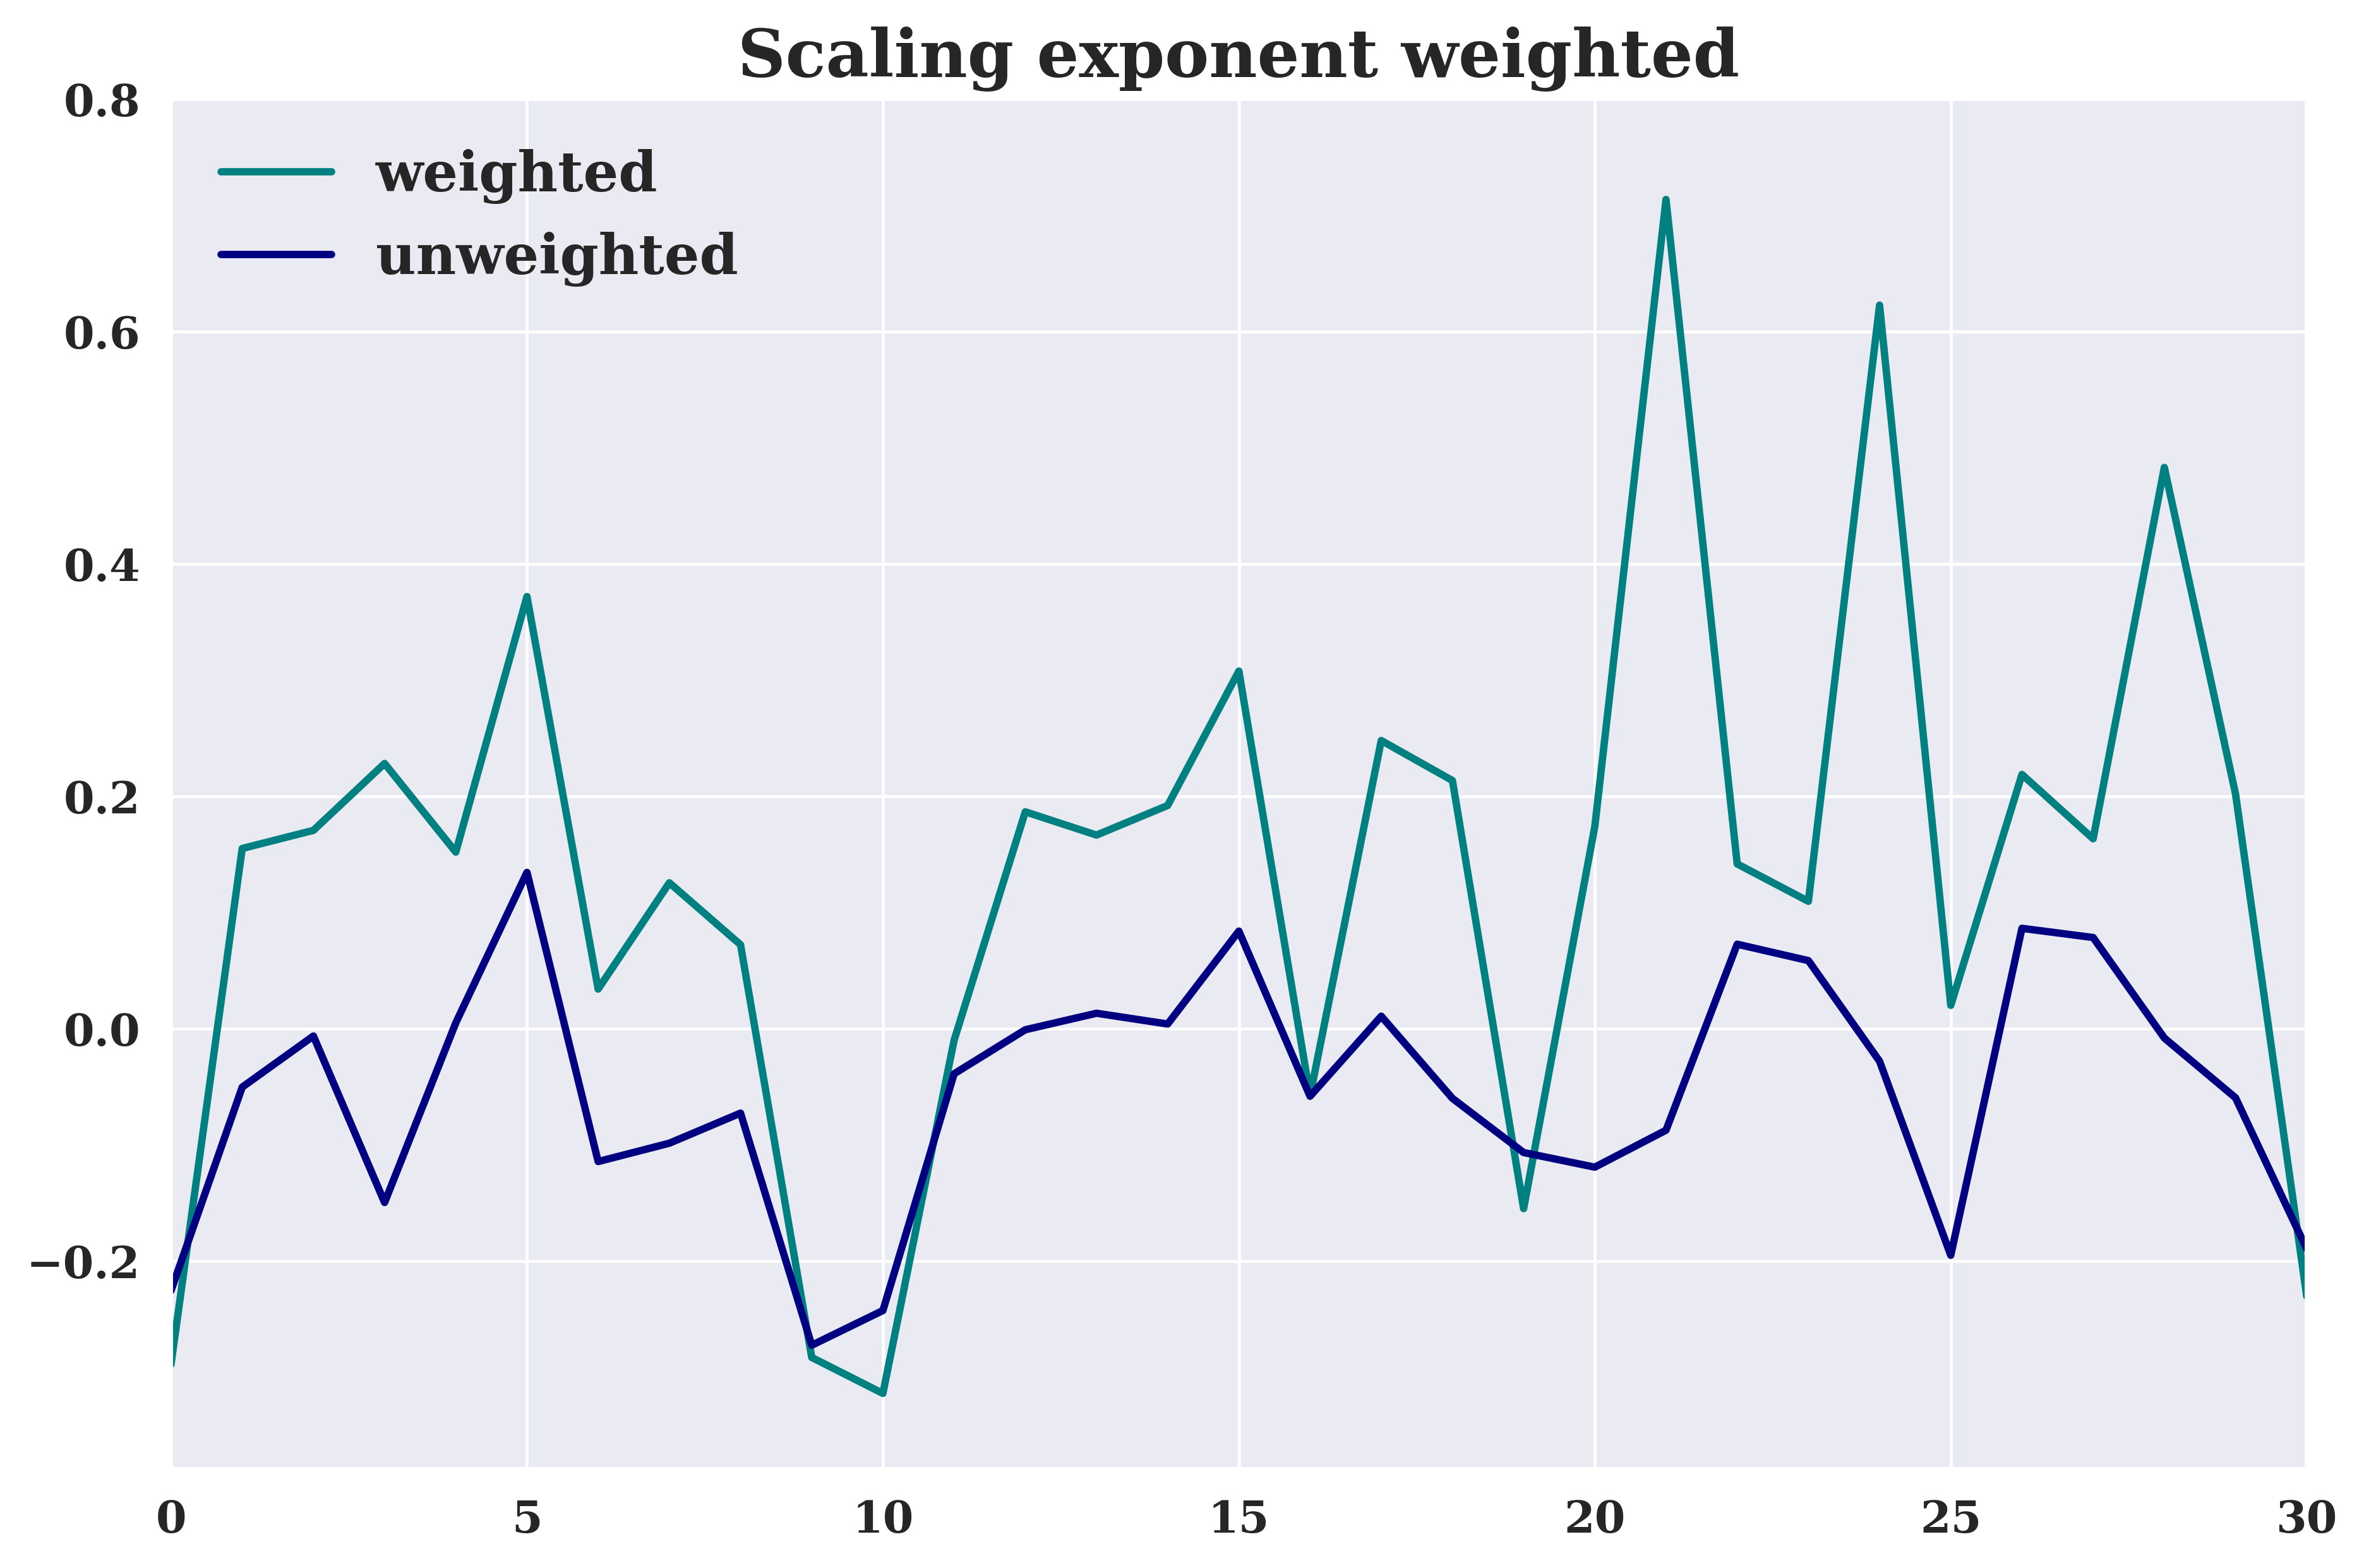

In [53]:
figg, axx = plt.subplots()
axx.plot(np.arange(fitp.shape[0]), fitp[:,act_idx,0], label='weighted' )
axx.plot(np.arange(fitp_unweighted.shape[0]), fitp_unweighted[:,act_idx,0], label='unweighted')
axx.set_title('Scaling exponent weighted')
#axx[1].set_title('Scaling exponent unweighted')
axx.legend()
axx.set_xlim([0,30])
#axx[1].set_xlim([0,30])

In [37]:
fitp[frame, act_idx,:]

array([-0.28866, -1.32711,  0.09719,  0.39878])

0.7137634011785835 -0.08718668050713006


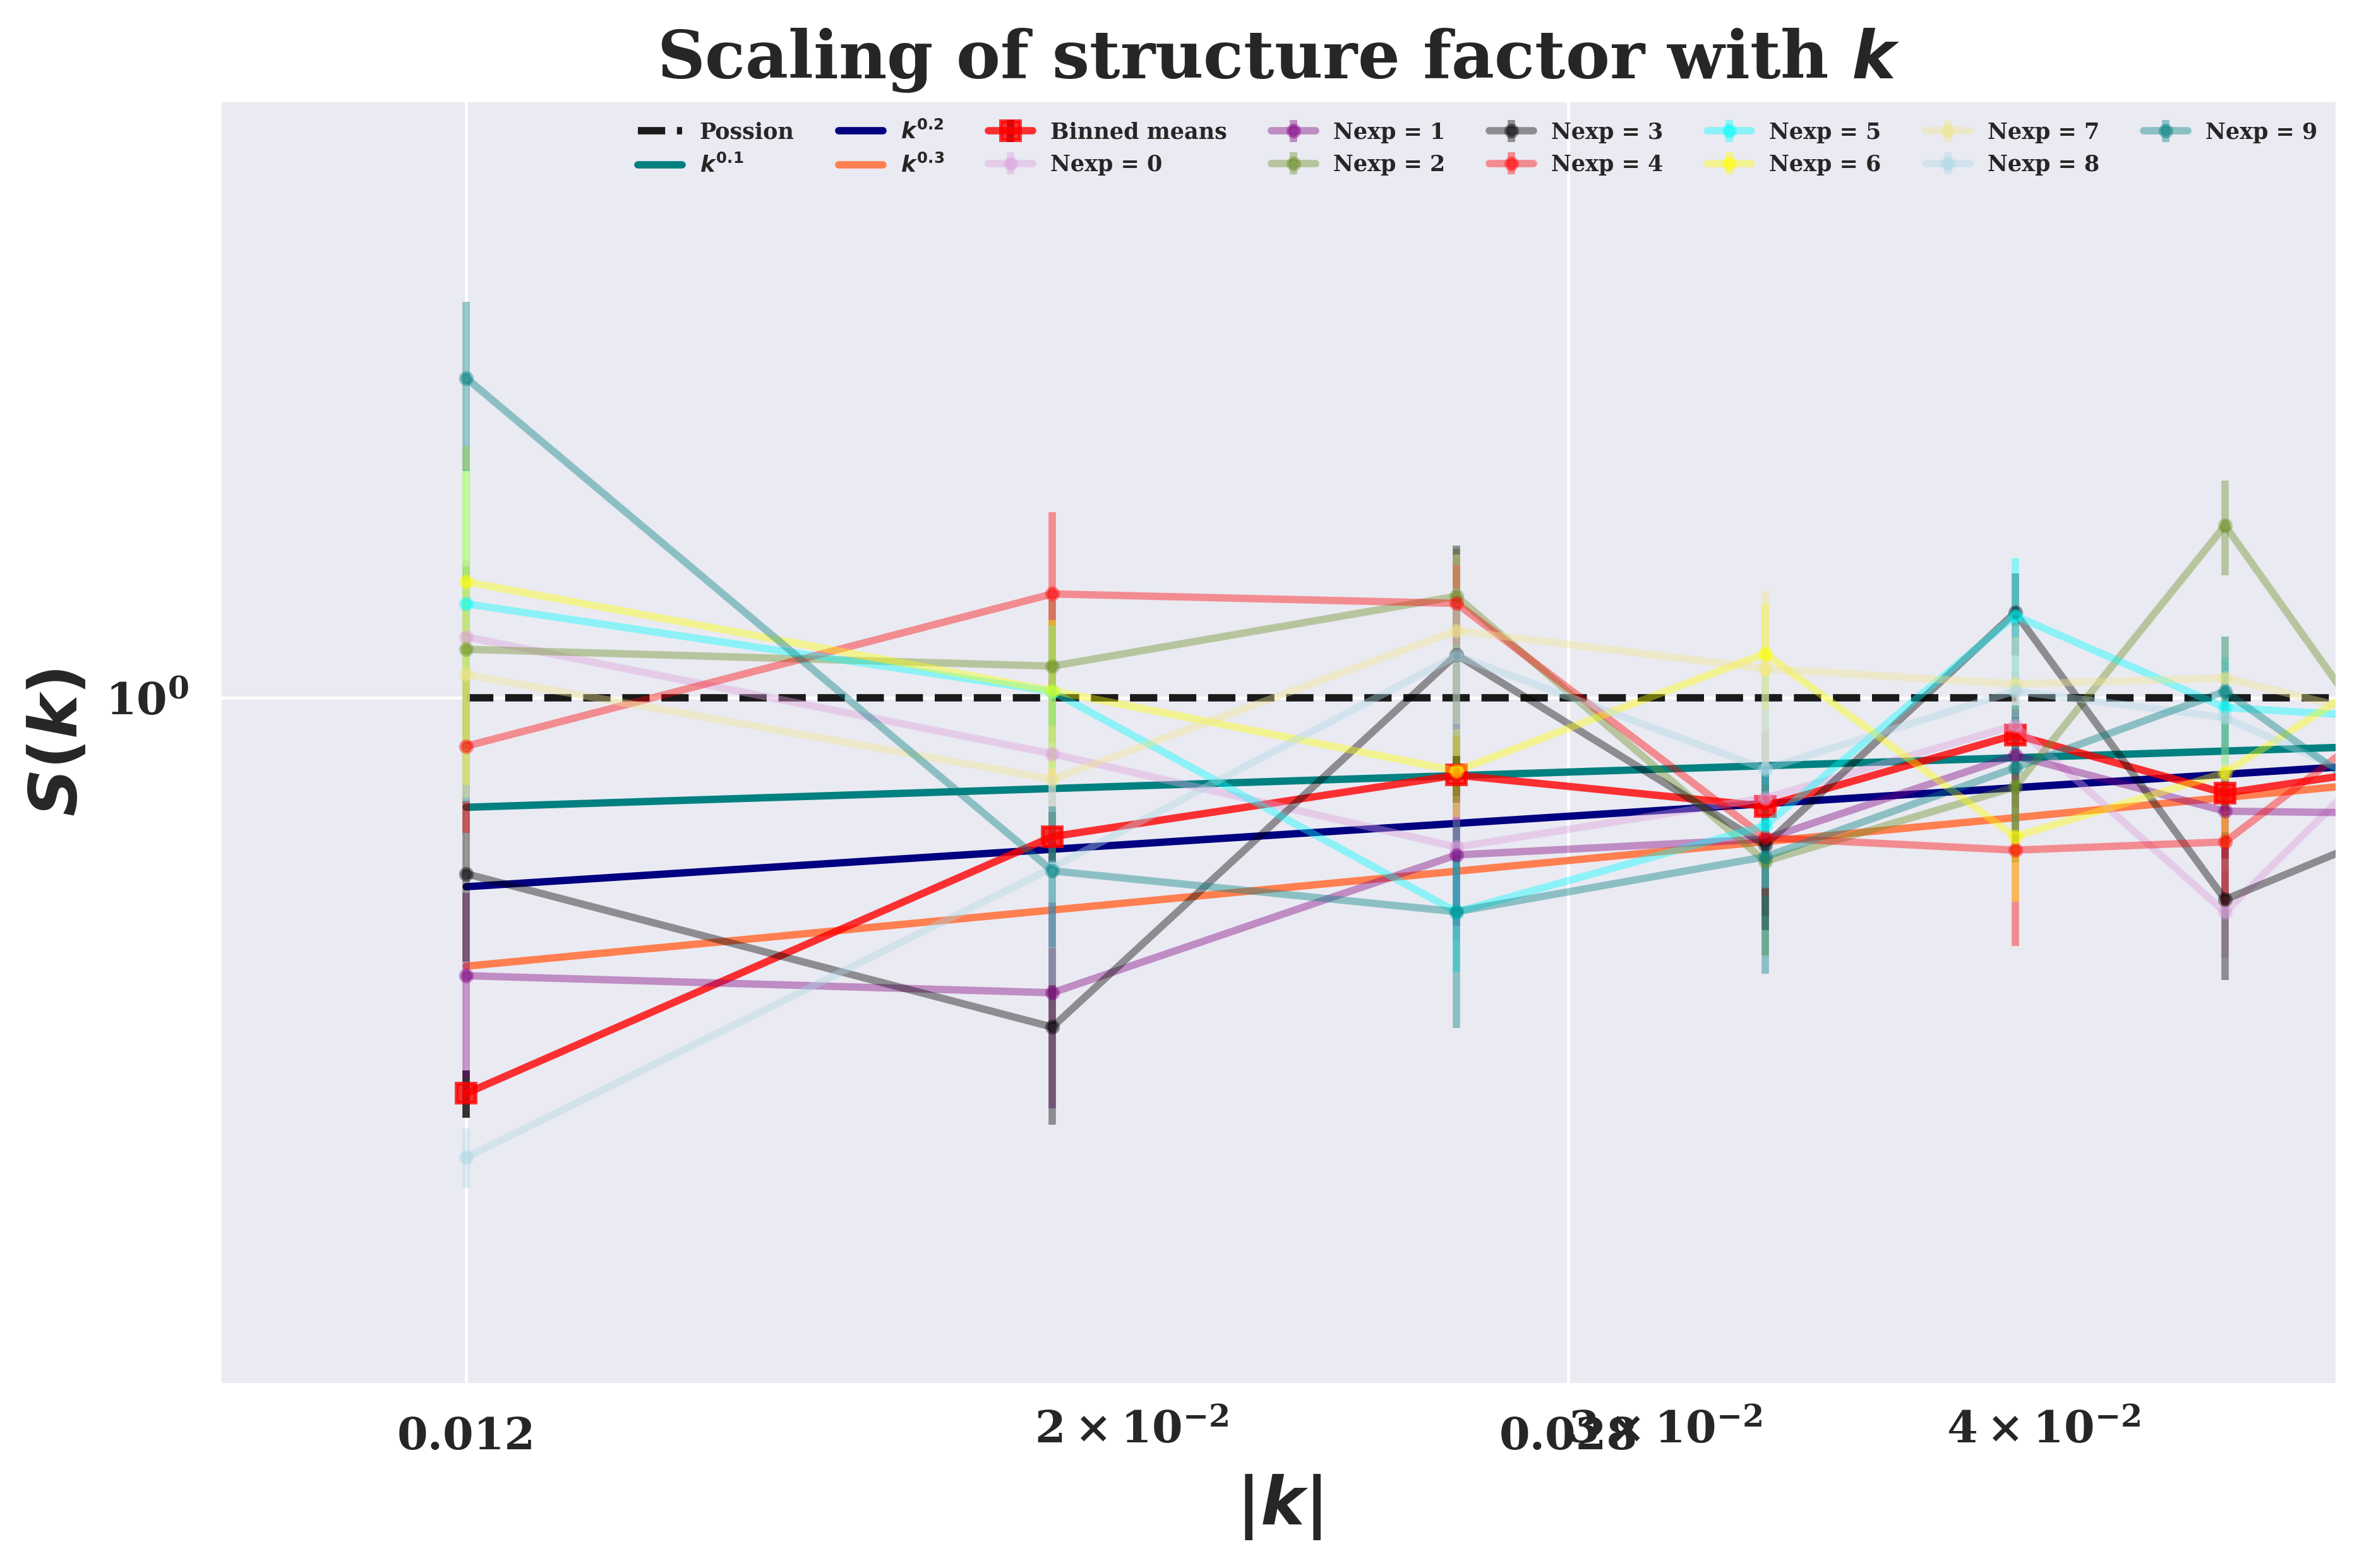

In [55]:
fig, ax = plot_structure_factor(kbins, sfac[frame, :, act_idx, 0], sfac[frame, :, act_idx, 1])
for i in range(sfac_full.shape[-1]):
    ax.errorbar(kbins, sfac_full[frame, :, 0, act_idx, i], sfac_full[frame, :, 1, act_idx, i], label = f'Nexp = {i}', marker='o', markersize=3,alpha=.4)
ax.legend(ncol=8, fontsize=6)
ax.set_xlim([0.01,0.05])
alpha_weighted = fitp[frame, act_idx, 0]
alpha_unwieghted = fitp_unweighted[frame, act_idx, 0]
print(alpha_weighted, alpha_unwieghted)

In [4]:
path = 'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data'

data_dirs = os.listdir(path)
data_dirs = [os.path.join(path, d) for d in data_dirs]

N = 6

ar = mp.archive.loadarchive(data_dirs[N])
data_dirs[N]

'C:\\Users\\Simon Andersen\\Dokumenter\\Uni\\Speciale\\Hyperuniformity\\nematic_data\\ns512_22'

In [96]:
os.listdir(data_dirs[N])

['frame200000.json',
 'frame200500.json',
 'frame201000.json',
 'frame201500.json',
 'frame202000.json',
 'frame202500.json',
 'frame203000.json',
 'frame203500.json',
 'frame204000.json',
 'frame204500.json',
 'frame205000.json',
 'frame205500.json',
 'frame206000.json',
 'frame206500.json',
 'frame207000.json',
 'frame207500.json',
 'frame208000.json',
 'frame208500.json',
 'frame209000.json',
 'frame209500.json',
 'parameters.json']

In [5]:
frame_interval = [0, 3]
Nframes = frame_interval[1] - frame_interval[0]
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
defect_list = get_defect_list(ar, LX, LY, frame_interval[0], Nframes)

In [6]:
Nf =2
defect_positions = get_defect_arr_from_frame(defect_list[Nf])

In [ ]:
LXB, LYB = 50, 50
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
method = 'fv'
method_kwargs = dict(method="c", spar=1, nknots=50)

df = calc_pair_corr_function(defect_positions, window, rmax=rmax, method=method, method_kwargs=method_kwargs)
df['pcf'] -= 1
fig, ax = plot_pair_corr_function(pcf_estimated=df)
ax.hlines(0, 0, rmax, linestyles='dashed', colors='k')

rvals = np.linspace(2,100,100)
yvals = rvals**-2 * rvals[0]**2 * 1.7
ax.plot(rvals, yvals, label=r'$r^{-2}$', color='red')

In [59]:
rmax

102.0

In [60]:
 (LX-LXB)/4 - 1

102.0

In [ ]:
LXB, LYB = 110, 110
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
method = 'fv'
method_kwargs = dict(method="b", spar=.7, nknots=150)

df = calc_pair_corr_function(defect_positions, window, rmax=rmax, method=method, method_kwargs=method_kwargs)
df['pcf'] -= 1
fig, ax = plot_pair_corr_function(pcf_estimated=df)
ax.hlines(0, 0, rmax, linestyles='dashed', colors='k')

rvals = np.linspace(2,100,100)
yvals = rvals**-2 * rvals[0]**2 * 1.7
ax.plot(rvals, yvals, label=r'$r^{-2}$', color='red')

In [ ]:
rvals = np.linspace(1,100,100)
yvals = rvals**-1
ax.plot(rvals + 10, yvals, label=r'$r^{-2}$', color='green')
fig

In [ ]:
LXB, LYB = 50, 50
window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
#window = BallWindow(center=[LX/2, LX/2], radius=(LX - LXB)/2-1) 
rmax = (LX-LXB)/4 - 1
method = 'fv'
method_kwargs = dict(method="c", spar=0.5, nknots=50)

df = calc_pair_corr_function(defect_positions, window, rmax=rmax, method=method, method_kwargs=method_kwargs)
df['pcf'] -= 1
fig, ax = plot_pair_corr_function(pcf_estimated=df)
ax.hlines(0, 0, 2*rmax, linestyles='dashed', colors='k')

In [152]:
LXB, LYB = 10, 10
box_window = BoxWindow(bounds=[[0+LXB, LX-LXB], [0+LYB, LY-LYB]])  
kmax = .5
direct = True
debiased = True
Nframes = frame_interval[1] - frame_interval[0]
nbins = 50

for i, frame in enumerate([Nf]):

    # Get defect array for frame
  #  defect_positions = get_defect_arr_from_frame(defect_list[i])

    if defect_positions is None:
        continue

    # Initialize point pattern
    point_pattern = PointPattern(defect_positions, box_window)
    t1 = time.time()

    # Use the family of sine tapers
    x = np.linspace(-2, 2, 80)
    x = x[x != 0]
   # k_sin = meshgrid_to_column_matrix(np.meshgrid(x, x))
    k_allowed = allowed_k_scattering_intensity(2, np.array([LX-2*LXB, LX-2*LXB]), k_max=1, meshgrid_shape=(80, 80))
    k_sin = k_allowed


    tapers = multi_sinetaper_grid(point_pattern.dimension, p_component_max=2)
    

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)

        sf = StructureFactor(point_pattern)
        k_sin1, sf_sin1 = sf.tapered_estimator(k_sin, tapers=tapers, debiased=debiased, direct=direct)
        k, sf_estimated = sf.scattering_intensity(k_max=kmax, debiased=debiased, direct=direct)
        #k, sf_estimated = sf.scattering_intensity(k_allowed, debiased=debiased, direct=direct)
        
    t2 = time.time()
    print("Time for structure factor: {}".format(t2 - t1))


    # Bin data
    knorms = np.linalg.norm(k, axis=1)
    kbins, smeans, sstds = bin_data(knorms, sf_estimated, bins=nbins,)

    kbins_arr = kbins.astype('float')
    sf_arr = np.zeros([Nframes, len(kbins_arr), 2]) * np.nan

    sf_arr[i, :, 0] = smeans
    sf_arr[i, :, 1] = sstds

Time for structure factor: 4.552700757980347


In [149]:
k_allowed = allowed_k_scattering_intensity(2, np.array([LX-2*LXB, LX-2*LXB]), k_max=1, meshgrid_shape=(80, 80))
np.linalg.norm(k_allowed, axis=1).min()

0.017700728837284328

In [143]:
defect_positions.max(axis=0)

array([511.5, 511.5])

In [52]:
tapers[0]

In [153]:
S = tapered_estimator_debiased_direct(k_allowed, point_pattern, taper=tapers[0])

In [119]:
k_allowed.shape

(104976, 2)

In [ ]:
ax = sf.plot_non_isotropic_estimator(
    k_sin1,
    S,
    plot_type="all",
    error_bar=True,
    bins=50,
    label=r"$\widehat{S}_{\mathrm{MDDTP}}((t_j)_1^4, \mathbf{k})$",
)
ax[1].set_xticks([0.01, 0.05, 0.1, 0.25], [0.01, 0.05, 0.1, 0.25]);

In [55]:
sf_sin1.shape

(6400,)

In [113]:
LX

512

In [ ]:
ax = sf.plot_non_isotropic_estimator(
    k_sin1,
    sf_sin1,
    plot_type="all",
    error_bar=True,
    bins=30,
    label=r"$\widehat{S}_{\mathrm{MDDTP}}((t_j)_1^4, \mathbf{k})$",
)
ax[1].set_xticks([0.01, 0.05, 0.1, 0.25], [0.01, 0.05, 0.1, 0.25]);

In [127]:
np.linalg.norm(k_allowed, axis=1).min(), np.linalg.norm(k, axis=1).min()

(0.034710022954362235, 0.017355011477181118)

In [ ]:
axx = sf.plot_non_isotropic_estimator(
    k,
    sf_estimated,
    plot_type="all",
    error_bar=True,
    bins=50,
    label=r"$\widehat{S}_I (\mathbf{k})$",
)
axx[1].set_xticks([0.01, 0.05, 0.1, 0.25], [0.01, 0.05, 0.1, 0.25]);

In [73]:
frame_interval = [0, 1]

LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
rmax = LX/4 - 1
window = BallWindow(center=[LX/2, LX/2], radius=LX/2-1) 
#window = BoxWindow(bounds=[[0, LX], [0, LY]])   

rad_arr, pcf_arr = get_pair_corr_function(ar, window, frame_interval = frame_interval, rmax = rmax, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2, nknots = 50))

R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



In [67]:

window = BoxWindow(bounds=[[0, LX], [0, LY]])   
top_defect_list = get_defect_list(ar, LX, LY, frame_interval[0], frame_interval[1])

kbins, sf_arr = get_structure_factor(ar, window, frame_interval = frame_interval, kmax = .5, debiased = True, direct = True, nbins = 50,)

Time for structure factor: 13.647084712982178


R[write to console]: number of data points exceeds 3000 - computing border correction estimate only



Time for pair correlation function: 3.3769824504852295


In [50]:
sf_arr.shape

(1, 50, 2)

In [ ]:
plot_structure_factor(kbins, np.nanmean(sf_arr[:, :, 0], axis = 0), np.nanstd(sf_arr[:, :, 0], axis = 0));

In [ ]:
plot_pair_corr_function(rad_arr = rad_arr, pcf_arr = pcf_arr[0], frame = frame_interval[0])

In [66]:
pcf_arr.shape

(1, 509)

In [ ]:
plot_pair_corr_function(rad_arr = rad_arr, pcf_arr = pcf_arr[0], frame = frame_interval[0])

In [ ]:
plot_pair_corr_function(rad_arr = rad_arr, pcf_arr = pcf_arr[0], frame = frame_interval[0])

In [ ]:
for i in range(pcf_arr.shape[0]):
    fig, ax = plot_pair_corr_function(rad_arr = rad_arr, pcf_arr = pcf_arr[i], frame = frame_interval[0] + i)


In [10]:
pcf_arr.shape

(3, 513)

In [91]:
frame_interval = [10,20]
rmax = 10
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
#LX = 1024
LY = LX
window = BoxWindow(bounds=[[0, LX], [0, LY]])   
top_defect_list = get_defect_list(ar, LX, LY, frame_interval[0], frame_interval[1])

kbins, sf_arr, rad_arr, pcf_arr = get_structure_factor(top_defect_list, window, kmax = .5, debiased = True, direct = True, nbins = 50,)

In [88]:
frame_interval = [10,20]
rmax = 10
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
#LX = 1024
LY = LX
window = BoxWindow(bounds=[[0, LX], [0, LY]])   


kbins, sf_arr, rad_arr, pcf_arr = get_structure_factor(ar, window, frame_interval = frame_interval, kmax = .5, debiased = True, direct = True, nbins = 50,)

TypeError: get_structure_factor() got an unexpected keyword argument 'LX'

In [ ]:
plot_structure_factor(kbins, np.nanmean(sf_arr[:, :, 0], axis = 0), np.nanstd(sf_arr[:, :, 0], axis = 0));

In [81]:
frame_interval = [0, 3]
rmax = 10
LX, LY = ar._read_frame(0).LX, ar._read_frame(0).LY
window = BallWindow(center=[LX/2, LX/2], radius=LX/3) 
window = BoxWindow(bounds=[[0, LX], [0, LY]])   

rad_arr, pcf_arr = get_pair_corr_function(ar, window, frame_interval = frame_interval, rmax = rmax, method = "fv", \
                            method_kwargs = dict(method="b", spar=0.2, nknots = 40))

In [98]:
print("SIZE OF R (MB): ", 181 * rad_arr.itemsize * rad_arr.size  / 1e6)

SIZE OF R (MB):  0.742824


In [94]:
r_crit = 1.5
Njump_small = 10
Njump_large = 3
idx_crit = np.argmin(np.abs(rad_arr - r_crit))

mask = (rad_arr < 0)

mask[np.arange(0, idx_crit, Njump_small)] = True
mask[np.arange(idx_crit, len(mask), Njump_large)] = True


print(mask.sum())

154


In [ ]:
fig, ax = plot_pair_corr_function(rad_arr = rad_arr[mask], pcf_arr = pcf_arr[0][mask], frame = frame_interval[0])

In [ ]:
fig, ax = plot_pair_corr_function(rad_arr = rad_arr[mask], pcf_arr = pcf_arr[0][mask], frame = frame_interval[0])